# The structure is the message: preserving experimental context through tensor decomposition

<h4 style="text-align: center;">Z. Cyrillus Tan, Aaron S. Meyer</h4>

In this demonstration, we provide an example of how to apply tensor methods to a synthetic example dataset. We will walk through all the analyses described in the text in order to provide a more comprehensive tutorial.

## 1. Import data and structure it to a tensor format

Throughout this work, we consider a synthetic dataset that records an experiment that profiles cells from seven organs responding to six candidate drugs over five time points.
First, we import the example dataset. Traditionally, a multivariate dataset like this is recorded as a spreadsheet, with some dimensions merged. For example, here, the drugs and time points are merged, so that each column represents a pair of drug-time point combinations. This is called MultiIndex in the `pandas` package.

In [6]:
import numpy as np
import pandas as pd
from os.path import join, dirname

data = pd.read_csv("example_drug_data.csv", 
                   delimiter=",", comment="#", index_col=0, header=[0, 1])
data

Alfazumab                                         Bravociclib  \
              1 hr      3 hr      6 hr     12 hr     24 hr        1 hr   
Thymus      7.5931  -74.0560 -156.3267 -152.0899 -129.2603     69.7114   
Skin       96.4908   97.6188  135.4522  106.3627  107.4902     84.3421   
Pancreas   82.8958   41.7587   43.6539    9.7820   -3.6321    116.1266   
Liver      54.0536   -2.0641  -29.5443  -51.6633  -55.9508    102.3161   
Heart     176.2525  118.8718  117.1203   95.2692  133.7000    126.5419   
Colon      45.5757  -33.6277 -102.2309 -101.4290  -71.5326     80.1902   
Kidney     90.7719   82.5750  116.1591   86.8304   76.0428     77.3614   

                                                  ... Echoxacin            \
              3 hr      6 hr     12 hr     24 hr  ...      1 hr      3 hr   
Thymus    111.0545  177.4723  161.4991  157.9950  ...   87.7958  200.3265   
Skin       68.4413   80.3329   67.1187   80.8065  ...   58.7727   19.6130   
Pancreas  123.8453  163.5675  149.8666  175.2404  ...  120.0887  172.2481   
Liver     122.6016  172.1183  158.7541  176.4939  ...  112.8466  189.4797   
Heart     127.0990  179.5757  136.0497  130.0312  ...  121.8980  182.4849   
Colon     113.8835  178.9411  155.4155  148.6795  ...   94.3906  200.4200   
Kidney     66.4917   78.0255   65.8033   83.3234  ...   73.4567   80.2512   

                                       Foxtrotolol                     \
              6 hr     12 hr     24 hr        1 hr     3 hr      6 hr   
Thymus    353.3183  317.5187  283.2818    -28.2758 -22.8253  -26.9893   
Skin        9.9165   -1.6546   -5.6995    -61.4324 -59.4331  -72.4681   
Pancreas  215.8126  226.1064  323.9284    -57.6145 -32.3156  -51.3740   
Liver     269.7720  268.1009  331.7243    -46.3147 -26.0519  -40.3760   
Heart     279.9835  239.0031  246.0975    -97.8848 -77.1348 -101.4701   
Colon     348.5009  308.1313  276.5570    -43.5885 -35.1011  -43.4352   
Kidney     69.3572   83.7880  172.3019    -47.7500 -26.8817  -43.6549   

                            
            12 hr    24 hr  
Thymus   -20.9940 -24.8508  
Skin     -62.6582 -80.3741  
Pancreas -23.2484  13.8744  
Liver    -18.4811   9.3109  
Heart    -73.2257 -64.2342  
Colon    -32.9590 -35.0784  
Kidney   -19.8480  12.6196  

[7 rows x 30 columns]

Although this MultiIndex format can represent the data faithfully, analyzing them as a spreadsheet/matrix muddles the relationship between drugs and time points. The columns are not equally related: some share drugs, some share time points, but many more have nothing in common. We sometimes call this spreadsheet a "flattened" version of the original dataset.

To make the structure reflect the right message, we convert the dataset into a tensor format. The original data has three modes: Organs, Drugs, and Time points, each having 7, 6, and 5 entries. Therefore, the tensor should be $7 \times 6 \times 5$. We print these out to have a more intuitive understanding of the data.

In [8]:
# Retrieve mode axes information
shape = (7, 6, 5)
axes_names = ["Organs", "Drugs", "Times"]
organs = data.index.tolist()
drugs = data.columns.get_level_values(0).unique().tolist()
times = data.columns.get_level_values(1).unique().tolist()
entry_names = [organs, drugs, times]
print(entry_names)

# Now convert the data into a three mode tensor
tensor = data.to_numpy().reshape(*shape)
tensor

[['Thymus', 'Skin', 'Pancreas', 'Liver', 'Heart', 'Colon', 'Kidney'], ['Alfazumab', 'Bravociclib', 'Charlivir', 'Deltatinib', 'Echoxacin', 'Foxtrotolol'], ['1 hr', '3 hr', '6 hr', '12 hr', '24 hr']]


array([[[   7.5931,  -74.056 , -156.3267, -152.0899, -129.2603],
        [  69.7114,  111.0545,  177.4723,  161.4991,  157.995 ],
        [  68.0527,  130.6083,  210.7125,  206.7382,  213.4184],
        [   0.5923,   80.0086,  179.5254,  144.0355,   87.8173],
        [  87.7958,  200.3265,  353.3183,  317.5187,  283.2818],
        [ -28.2758,  -22.8253,  -26.9893,  -20.994 ,  -24.8508]],

       [[  96.4908,   97.6188,  135.4522,  106.3627,  107.4902],
        [  84.3421,   68.4413,   80.3329,   67.1187,   80.8065],
        [  47.7073,   56.7609,   56.444 ,   71.3942,  124.8541],
        [ -41.5447,  -85.8681, -117.5078, -127.2689, -174.8336],
        [  58.7727,   19.613 ,    9.9165,   -1.6546,   -5.6995],
        [ -61.4324,  -59.4331,  -72.4681,  -62.6582,  -80.3741]],

       [[  82.8958,   41.7587,   43.6539,    9.782 ,   -3.6321],
        [ 116.1266,  123.8453,  163.5675,  149.8666,  175.2404],
        [  58.2814,   41.5263,   94.9442,   68.5988,  -16.8659],
        [  -8.7859,  

## 2. Perform CP decomposition on the data

Let's assume this tensor is already properly proprocessed. Now, we perform a CP (also called PARAFAC or CANDECOMP) decomposition on it. Here, we tentatively choose 4 components. Throughout this demonstration, we use `TensorLy`, a commonly used Python tensor package. To see alternative options, check Tbl. 2 in the text.

In [11]:
from tensorly.decomposition import parafac

cp = parafac(tensor, 3)

In the `TensorLy` package, the CP results are stored as two sets of values: weights and factors. Weights are vectors of values, and factors are sets of factor matrices. Unnormalized weights are all 1.

In [13]:
cp[0]

array([1., 1., 1.])

Since our data is a 3-mode tensor, there should be three factor matrices. For a 3-component decomposition, these matrices should have sizes $7 \times 3$, $6 \times 3$, and $5 \times 3$, respectively. They are the factor matrices of organ, drug, and time modes, as drawn in Fig. 2b, right.

In [15]:
cp[1]

[array([[ 274.64169957,  -14.79200921, -149.12287797],
        [ 503.59685754,  -27.51843979,   16.10666417],
        [ 632.18068065,   33.92925401,  -68.2982001 ],
        [ 513.90114321,   19.42504466, -100.37113855],
        [ 859.91732879,   86.79388985,  -41.93656738],
        [ 397.76813848,   11.43466963, -128.20282009],
        [ 503.36243637,   54.0652088 ,    3.66731937]]),
 array([[ 0.43901696,  0.00722143, -1.38734364],
        [ 0.38562811, -0.15236277,  0.82226257],
        [ 0.19256511, -1.589673  ,  1.08228365],
        [-0.18231082,  2.11621792,  1.34270882],
        [ 0.27626033,  0.69444713,  2.08236156],
        [-0.26303276,  0.34441116,  0.12923539]]),
 array([[ 0.41914428,  0.45568069, -0.19249686],
        [ 0.37305043,  0.82617892, -0.58293319],
        [ 0.47631714,  0.89684467, -1.03346475],
        [ 0.38817167,  1.09352939, -0.96188274],
        [ 0.42631597,  1.94450497, -0.91325084]])]

Each component can be represented as three factor vectors. For example, Component 1 can be represented as the first vectors across three modes. They are:

In [17]:
print(cp[1][0][:, 0])
print(cp[1][1][:, 0])
print(cp[1][2][:, 0])

[274.64169957 503.59685754 632.18068065 513.90114321 859.91732879
 397.76813848 503.36243637]
[ 0.43901696  0.38562811  0.19256511 -0.18231082  0.27626033 -0.26303276]
[0.41914428 0.37305043 0.47631714 0.38817167 0.42631597]


These three vectors exactly correspond to the blue, orange, and green vectors shown in Fig. 2b, shaded box in the middle. Although represented as three vectors, Component 1 is in fact a rank-one tensor of $7 \times 6 \times 5$ dimension, which is

In [19]:
from tensorly.tenalg import outer
outer([cp[1][0][:, 0], cp[1][1][:, 0], cp[1][2][:, 0]])

array([[[  50.53721762,   44.97957306,   57.43068344,   46.80277657,
           51.40192438],
        [  44.39138602,   39.50960668,   50.44653738,   41.11109039,
           45.15093578],
        [  22.16703631,   19.72929805,   25.1907031 ,   20.52900607,
           22.54632086],
        [ -20.98661831,  -18.67869218,  -23.84927167,  -19.43581491,
          -21.34570557],
        [  31.80156939,   28.30430881,   36.13942259,   29.4515966 ,
           32.34570366],
        [ -30.2788845 ,  -26.94907559,  -34.40903778,  -28.04143031,
          -30.79696518]],

       [[  92.66758844,   82.47681136,  105.30779466,   85.81992917,
           94.25315831],
        [  81.39828197,   72.44680541,   92.50131257,   75.38336662,
           82.79103067],
        [  40.64659461,   36.17663492,   46.19094238,   37.64301984,
           41.34206987],
        [ -38.4821207 ,  -34.25019107,  -43.73122613,  -35.63848945,
          -39.14056118],
        [  58.31295988,   51.90020668,   66.26706607,   54

This is called a rank-one 3-mode tensor because it can be computed exactly as the outer product of three vectors (therefore recovers a 3-mode tensor). See Figs. 1e-1g to see how this works. 
In CP decomposition, we write our original data tensor as the sum of 3 rank-one tensors (because we earlier chose the number of components to be 3, not because it has 3 modes). We can say that we break our original data down into three separate signals. Since rank-one tensors are easier to interpret, by reading into each component, we get to understand what information is contained in the data.

## 3. Choosing the number of components
How do we choose the number of components for CP decomposition? The most basic method involves comparing the fitting error of each option. The reconstruction error is defined as the sum of squared differences between the original tensor and the reconstructed tensor, normalized (i.e. divided by) the sum of squares of the original data. This is equivalent to $1 - R^2$. We write a function to compute this value.

In [22]:
import seaborn as sns
from tensorly.cp_tensor import CPTensor
from tensorly.tucker_tensor import TuckerTensor, tucker_to_tensor
from tensorly.tenalg import multi_mode_dot

def error(original, res):
    # res is in CP
    if isinstance(res, CPTensor):
        res = res.to_tensor()
    
    # deal with cases when res is Tucker
    if isinstance(res, TuckerTensor):
        res = tucker_to_tensor(res)
        
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)

To choose the optimal number of components, we need to first experiment with a range of numbers and find their fitting errors (Fig. 2c):

<Axes: xlabel='Num of Comps.', ylabel='Error'>

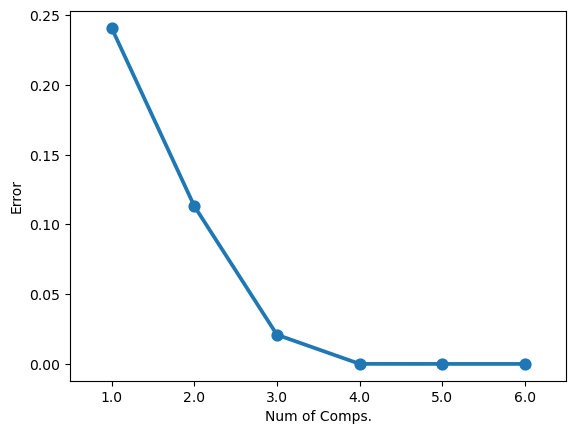

In [24]:
errors = pd.DataFrame(columns=["Num of Comps.", "Error"])
for rr in np.arange(1, 7):
    errors.loc[len(errors)+1] = [rr, error(tensor, parafac(tensor, rr))]

sns.pointplot(data=errors, x="Num of Comps.", y="Error")

The fitting error consistently decreases with a greater number of components. We do not want a perfect fit; instead, we identify where the benefit of adding more components diminishes. This can be found as the elbow point (or kink) on the plot above. Here, we can see that it is at the 3rd component. Therefore, from now on, we can confidently choose 3 components for our dataset.

In [26]:
rank = 3
cp = parafac(tensor, rank)

### Compare CP and PCA performance

The number of components chosen directly relates to the data compression efficiency and fidelity trade-off. Basically, when we choose more components, the reconstructed tensor has lower error, but with the cost of needing more parameters. We compare this relationship between CP and principal component analysis (PCA) performed on the original flattened matrix.

In [28]:
reduction = pd.DataFrame(columns=["Size", "Error", "Method", "Data"])

# Add CP reduction
for rr in np.arange(1, 10):
    reduction.loc[len(reduction)+1] = [rr * np.sum(tensor.shape),
                                 error(tensor, parafac(tensor, rr, tol=1e-09)),
                                 "CP",
                                 "Original data"]

A n-component CP decomposition needs $n \times (7+6+5)$ parameters.

In [30]:
from sklearn.decomposition import PCA

flatten = tensor.reshape(tensor.shape[0], -1)
pca = PCA(n_components=flatten.shape[0])
pca.fit(flatten)
pca_errors = 1 - np.cumsum(pca.explained_variance_ratio_)
pca_sizes = np.sum(flatten.shape) * np.arange(1, flatten.shape[0] + 1)
for rr in range(flatten.shape[0]-1):

    reduction.loc[len(reduction)+1] = [pca_sizes[rr],
                                pca_errors[rr],
                                 "PCA",
                                 "Original data",]

A n-component PCA on a flattened matrix needs $n \times (7+6 \times 5)$ parameters.

<Axes: xlabel='Size', ylabel='Error'>

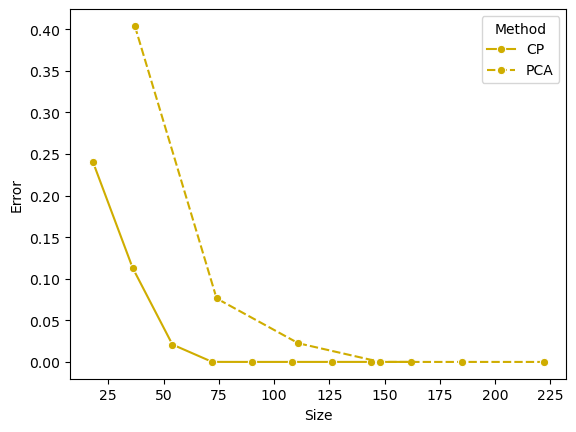

In [32]:
sns.lineplot(data=reduction, x="Size", y="Error", style="Method", markers=["o", "o"], color="#CFAD00")

As we can see here, CP compresses the data more efficiently than PCA. Note that in this case, we cannot compare an n-component CP and an n-component PCA directly, as they are different in both parameters needed and fitting errors.

Nonetheless, CP decomposition is not always better than PCA; it depends on the underlying data structure. Here, we can do an experiment to demonstrate this (Fig). First, we create two new datasets by randomly shuffling the chords (defined in Fig. 2a) and all numbers in the original datasets. This will break the underlying low-rank structure in the data.

In [34]:
# Shuffle the chords / columns
col_tensor = tensor.reshape(tensor.shape[0], -1)
col_tensor = col_tensor[:, np.random.permutation(col_tensor.shape[1])]
col_tensor = col_tensor.reshape(*tensor.shape)

# Shuffle all numbers
rng = np.random.default_rng(123)
rand_tensor = rng.permutation(tensor.flatten()).reshape(*tensor.shape)

We now compare the CP and PCA errors when run on the original datasets and these two new datasets. 

<Axes: xlabel='Size', ylabel='Error'>

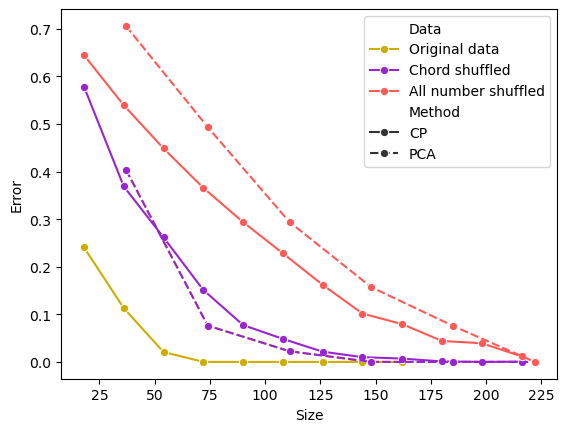

In [36]:
for rr in np.arange(1, 13):
    reduction = pd.concat([reduction, pd.DataFrame([{
                        'Size': rr * np.sum(col_tensor.shape),
                        'Error': error(col_tensor, parafac(col_tensor, rr, tol=1e-09)),
                        'Method': "CP",
                        'Data': 'Chord shuffled',
                    }])], ignore_index=True)
    reduction = pd.concat([reduction, pd.DataFrame([{
                        'Size': rr * np.sum(rand_tensor.shape),
                        'Error': error(rand_tensor, parafac(rand_tensor, rr, tol=1e-09)),
                        'Method': "CP",
                        'Data': 'All number shuffled',
                    }])], ignore_index=True)
    
# Find PCA data reduction
# Chords shuffled
col_flatten = col_tensor.reshape(col_tensor.shape[0], -1)
col_pca = PCA(n_components=col_flatten.shape[0])
col_pca.fit(col_flatten)
col_pca_errors = 1 - np.cumsum(col_pca.explained_variance_ratio_)
col_pca_sizes = np.sum(col_flatten.shape) * np.arange(1, col_flatten.shape[0] + 1)

# All number shuffled
rand_flatten = rand_tensor.reshape(rand_tensor.shape[0], -1)
rand_pca = PCA(n_components=rand_flatten.shape[0])
rand_pca.fit(rand_flatten)
rand_pca_errors = 1 - np.cumsum(rand_pca.explained_variance_ratio_)
rand_pca_sizes = np.sum(rand_flatten.shape) * np.arange(1, rand_flatten.shape[0] + 1)
for rr in range(rand_flatten.shape[0]-1):
    reduction = pd.concat([reduction, pd.DataFrame([{
                    'Size': col_pca_sizes[rr],
                    'Error': col_pca_errors[rr],
                    'Method': "PCA",
                    'Data': 'Chord shuffled',
                }])], ignore_index=True)
    
    reduction = pd.concat([reduction, pd.DataFrame([{
                    'Size': rand_pca_sizes[rr],
                    'Error': rand_pca_errors[rr],
                    'Method': "PCA",
                    'Data': 'All number shuffled',
            }])], ignore_index=True)

sns.lineplot(data=reduction, x="Size", y="Error", hue="Data", style="Method", marker="o", 
             palette=["#CFAD00", "#9A24D1", "#FF5956"])

As we can see here, the chord shuffle harms the fitting of CP, and all number shuffle even worsens it. Permuting chords in a tensor is equivalent to shuffling the columns in its flattened matrix, which does not impact the performance of PCA at all. Therefore, the PCA curves for the original data and the chord-shuffled version perfectly overlap. However, PCA performs much worse on the all-number-shuffled datasets.

## 4. Visualize the results with heatmaps

We now visualize the decomposition results. To visualize these factor matrices, we plot heatmaps for each of them, one for each mode.

In [40]:
import matplotlib
from matplotlib import gridspec, pyplot as plt

def plot_factors(res):
    ddims = len(res[1])
    f = plt.figure(figsize=(5*ddims, 6))
    gs = gridspec.GridSpec(1, ddims, wspace=0.5)
    axes = [plt.subplot(gs[rr]) for rr in range(ddims)]
    
    factors = [pd.DataFrame(res[1][rr],
                        columns=[f"Cmp. {i}" for i in np.arange(1, res[1][rr].shape[1]+1)],
                        index=[organs, drugs, times][rr])
               for rr in range(ddims)]
    
    for rr in range(ddims):
        sns.heatmap(factors[rr], cmap="vlag", center=0, 
                    xticklabels=[str(ii+1) for ii in range(res[1][rr].shape[1])], 
                    yticklabels=factors[rr].index,
                    cbar=True, vmin=-1.0, vmax=1.0, ax=axes[rr])
        axes[rr].set_xlabel("Components")
        axes[rr].set_title(axes_names[rr])

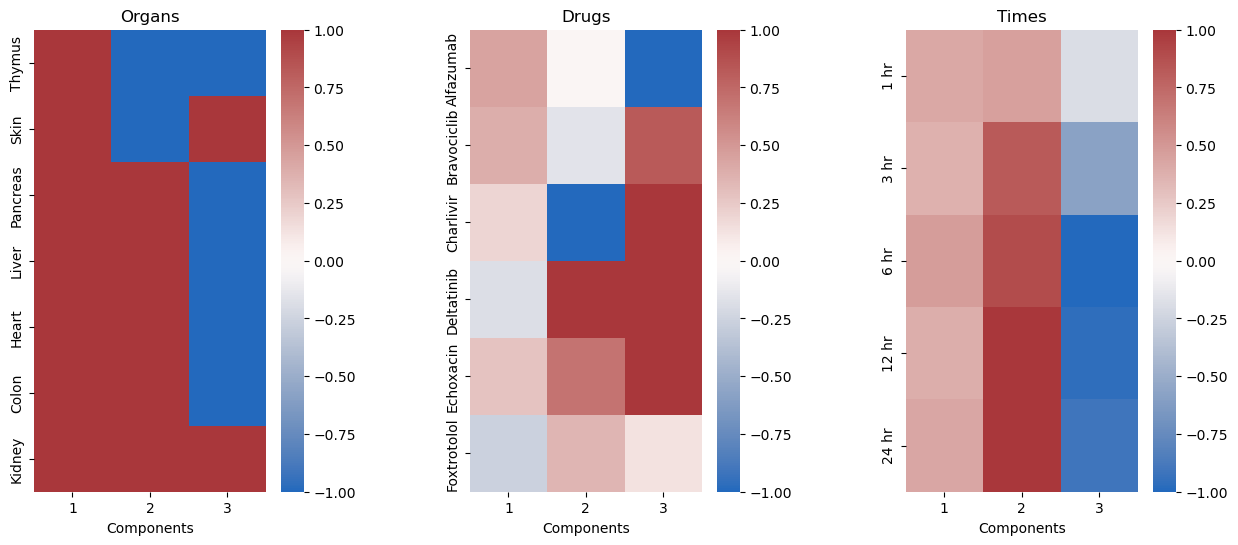

In [41]:
plot_factors(cp)

By default setting of the `parafac` function, the weights are all 1, and the factor matrices are unnormalized. Therefore, the colors in some blocks are at the strongest ends because these weights are far beyond +1 and -1, making them hard to compare directly. To better visualize the results, we perform two additional steps to normalize the results:
1. We scale the factor matrix columns so that the largest weight in each column is 1. The weights are shifted to the weights, `cp[0]`. We then sort the components by their weights. These operations will give us an equivalent decomposition.

In [43]:
def factor_scaling(res: CPTensor):
    """ Scale the factor matrices so that they are in plottable scales. """
    for i, factor in enumerate(res.factors):
        scales = np.linalg.norm(factor, ord=np.inf, axis=0)
        res.weights *= scales
        res.factors[i] /= scales

    comp_order = np.flip(np.argsort(res.weights))
    res.weights = res.weights[comp_order]
    for i, factor in enumerate(res.factors):
        res.factors[i] = factor[:, comp_order]
    return res

cp = factor_scaling(cp)

2. We invert the signs of the factor weights of any component that have negative weights on two modes. This will ensure that at most one mode contains strong negative weights.

In [45]:
def sign_indeterminacy(res: CPTensor):
    """ Fix CP decomposition sign indeterminacy by flipping signs in pairs of modes. """
    ddims = len(res[1])
    for rr in range(ddims-1):
        mmeans = np.sign(np.mean(res.factors[rr], axis=0))
        res.factors[rr] *= mmeans[np.newaxis, :]
        res.factors[rr+1] *= mmeans[np.newaxis, :]
    return res

cp = sign_indeterminacy(cp)

Check out Fig. 2i to learn more about factors' scale indeterminacy and why these two operations above will give us equivalent decomposition results.
Now we plot the factor matrices again (Fig. 2f).

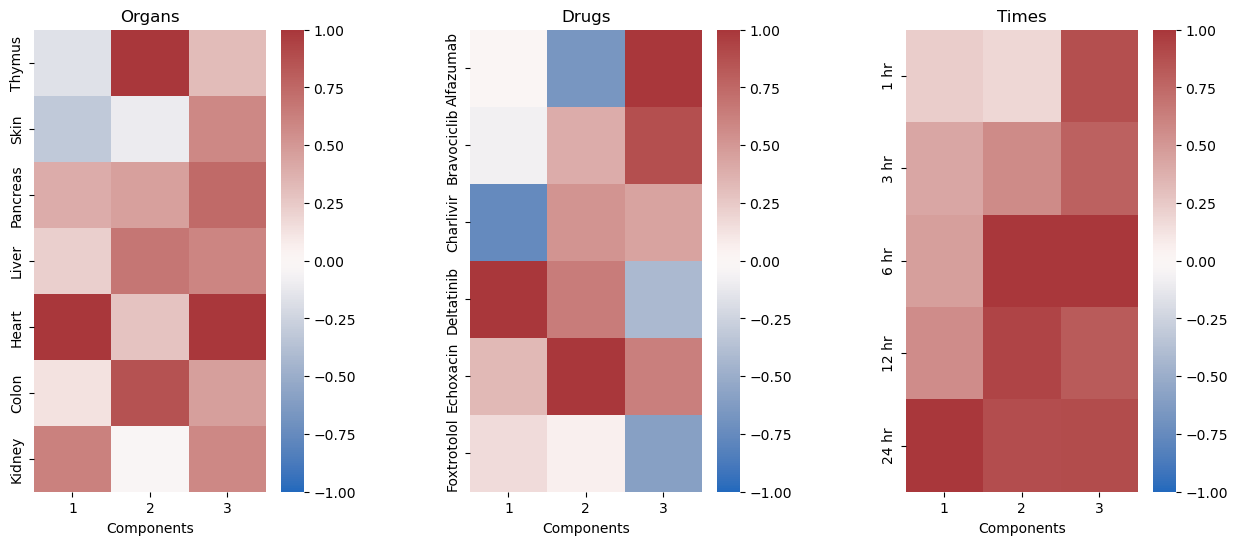

In [47]:
plot_factors(cp) 

Now all values in the heatmaps are in reasonable ranges, easing the interpretation process.

## 5. Other options for visualizing the results

Heatmaps are sometimes not the most intuitive way of visualizing factors. Therefore, here we show a few other options to demonstrate the tensor decomposition results.

### Looking into one component
To inspect one component, we can make a bar plot for each factor of the three modes (Fig. 2e):

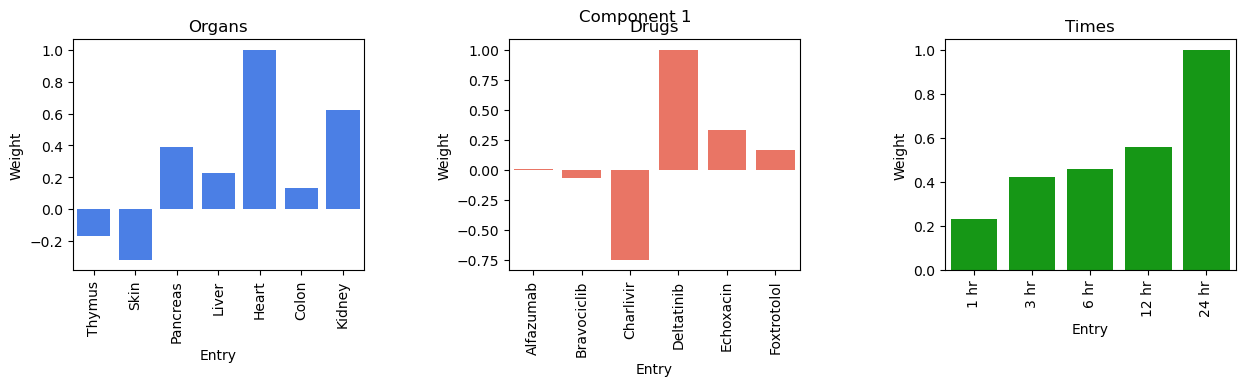

In [51]:
def plot_one_component(res, i_comp=1):
    ddims = len(res[1])
    f = plt.figure(figsize=(5*ddims, 3))
    gs = gridspec.GridSpec(1, ddims, wspace=0.5)
    axes = [plt.subplot(gs[rr]) for rr in range(ddims)]
    
    bar_colors = ["#3177FF", "#FF644F", "#00AD01"]
    
    for rr in range(ddims):
        sns.barplot(data = pd.DataFrame(data={"Entry": entry_names[rr], "Weight": cp[1][rr][:, i_comp-1]}),
                    x='Entry', y='Weight', color=bar_colors[rr], ax=axes[rr])
        
        axes[rr].set_title(axes_names[rr])
        axes[rr].tick_params(axis='x', rotation=90)
        
    f.suptitle(f"Component {i_comp}")

plot_one_component(cp, i_comp=1)

### Looking into one mode
Alternatively, we can also compare the factors across components within one mode. Depending on the nature of the mode, one can either choose a barplot or a lineplot.
Bar plot usually works well for discrete labels such as samples or treatments. In our case, organs and drugs are discrete labels. Here is a bar plot for drug factors (Fig. 2g).

Text(0.5, 1.0, 'Drug factors')

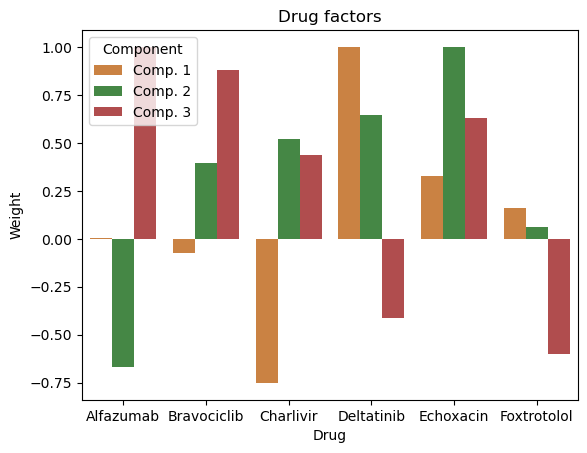

In [53]:
drug_factors = pd.DataFrame(cp[1][1], columns=[f"Comp. {rr}" for rr in np.arange(1, rank+1)], index=drugs)
drug_factors.index.name = "Drug"
drug_factors = drug_factors.reset_index().melt(id_vars=['Drug'], 
                                               value_vars=[f"Comp. {rr}" for rr in np.arange(1, rank+1)],
                                               var_name="Component", value_name='Weight')

sns.barplot(data=drug_factors, x="Drug", y="Weight", hue="Component", 
            palette= ["#E1812C", "#3A923A", "#C03D3E"]).set_title("Drug factors")

Line plot usually works better for continuous labels, such as time or concentration. Here is a line plot for time factors (Fig. 2h)

Text(0.5, 1.0, 'Time point factors')

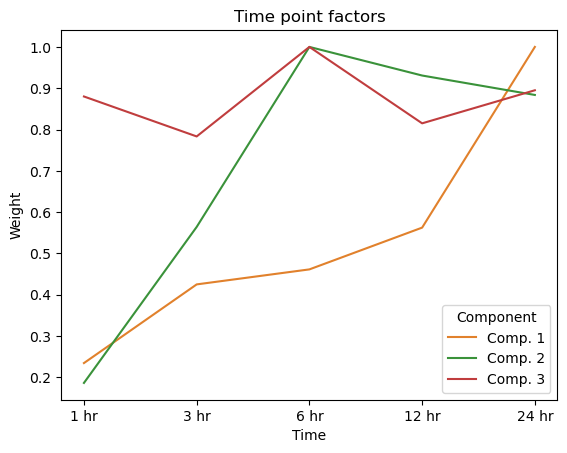

In [55]:
time_factors = pd.DataFrame(cp[1][2], columns=[f"Comp. {rr}" for rr in np.arange(1, rank+1)], index=times)
time_factors.index.name = "Time"
time_factors = time_factors.reset_index().melt(id_vars=['Time'], 
                                               value_vars=[f"Comp. {rr}" for rr in np.arange(1, rank+1)],
                                               var_name="Component", value_name='Weight')

sns.lineplot(data=time_factors, x="Time", y="Weight", hue="Component", 
             palette=["#E1812C", "#3A923A", "#C03D3E"]).set_title("Time point factors")

## 6. Use factor matrix to find associations among organs

A factor matrix can serve as reduced and summarized data for its mode. For example, we can run hierarchical clustering to the factor matrix to reveal the association among the mode entries (Fig. 2j).

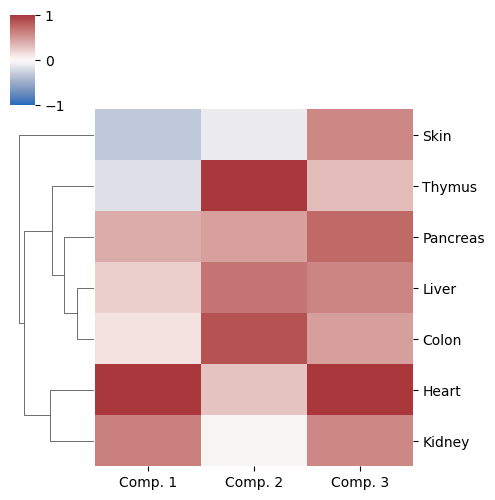

In [57]:
df_organ = pd.DataFrame(data=cp[1][0], columns=[f"Comp. {rr}" for rr in np.arange(1, rank+1)], index=organs)
sns.clustermap(df_organ, col_cluster=False, method='average', 
               cmap="vlag", vmin=-1.0, vmax=1.0, figsize=(5, 5)) 

## 7. Missing value and imputation test

Many tensor factorization methods allow the data to contain missing values. Some factorization algorithms have quite high tolerance for missing values (for example, some prefilled value methods can theoretically allow 100% missing values). However, the factorization results with a lot of missing values would deviate from what the factors would have been if there was no missingness. Here, we experiment with adding random missing values to our drug response dataset and see how the proportion of missingness relates to the recontruction errors (Fig. 3d).

<Axes: xlabel='Missing proportion', ylabel='Error'>

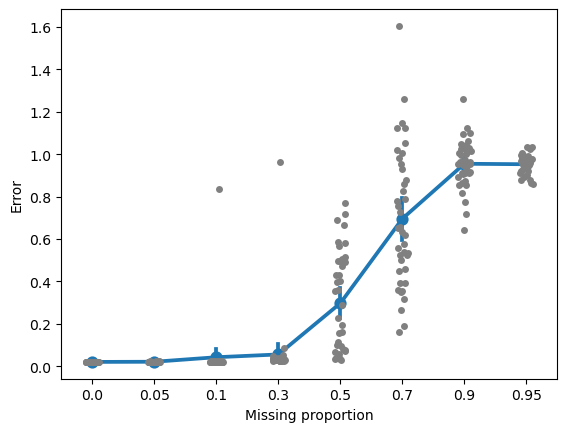

In [59]:
missing_value_errors = []
missing_value_proportions = [0.0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
np.random.seed(1234)

for miss_ratio in missing_value_proportions:
    # for each proportion, we try 40 random missingness.
    for rep in range(40):
        unmask = np.random.rand(*tensor.shape) < 1 - miss_ratio
        masked_tensor = np.copy(tensor)
        masked_tensor[~unmask] = 1.0
        cp_masked = parafac(masked_tensor, 3, mask=unmask)
        recon_error = error(tensor, cp_masked.to_tensor())
        missing_value_errors.append((miss_ratio, recon_error))

missing_value_df = pd.DataFrame(missing_value_errors, columns=["Missing proportion", "Error"])

sns.stripplot(data=missing_value_df, x="Missing proportion", y="Error", color="gray")
sns.pointplot(data=missing_value_df, x="Missing proportion", y="Error")

As we can see here, more missingness comes with worse reconstruction errors.

The imputation test has adopted the idea of artificially introducing missing values to test the decomposition (Fig. 3e). Basically, the imputation test randomly removes a portion of the data and sees if the reconstructed tensor can impute the removed data. A low imputation error indicates that the decomposition can even fit the unseen data well, which is a strong signal that the decomposition works. This can also be used to determine the number of components.

<Axes: xlabel='Components', ylabel='Value'>

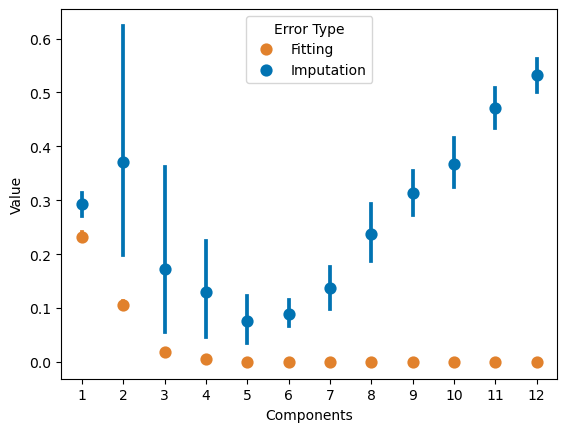

In [61]:
imputation_test = []
np.random.seed(1234)

for rep in range(30):
    unmask = np.random.rand(*tensor.shape) < 0.7
    # this is equivalent to masking 30% of values to be missing
    for rr in np.arange(1, 13):
        masked_tensor = np.copy(tensor)
        masked_tensor[~unmask] = 0.0
        cp_masked = parafac(masked_tensor, rr, mask=unmask)
        fitting_error = error(tensor[unmask], cp_masked.to_tensor()[unmask])
        imputation_error = error(tensor[~unmask], cp_masked.to_tensor()[~unmask])
        imputation_test.append((rr, "Fitting", fitting_error))
        imputation_test.append((rr, "Imputation", imputation_error))

imputation_df = pd.DataFrame(imputation_test, columns=["Components", "Error Type", "Value"])

sns.pointplot(data=imputation_df, x="Components", y="Value", hue="Error Type", 
              linestyle="none", palette=["#E1812C", "#0173B2"])

The result shows that while the fitting errors monotonically decrease with more components, the imputation errors can increase with too many components. Sometimes, the imputation errors can be very off. From this plot, it seems like a 5-component model best imputes unseen data.

## 8. Factor sparsity

Sparsity means that most elements in an array are zero. A sparse factor can be easier to interpret as the association is clearer. The following code uses Lasso, a regularization method, to achieve sparsity. It simulates one step in the alternating least squares scheme. Here, we show the first factors of the organ mode under three different levels of sparsity (Fig. 3f).

<Axes: >

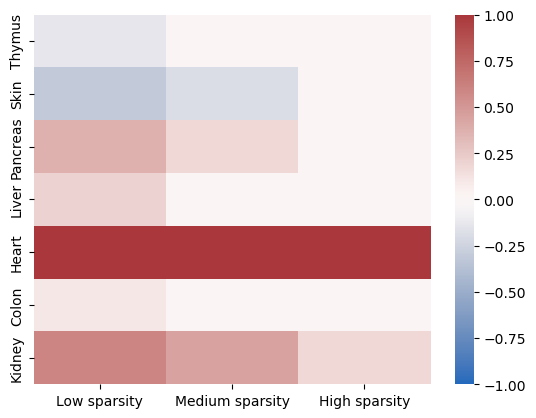

In [64]:
from tensorly.tenalg import khatri_rao
from sklearn.linear_model import Lasso

lasso_alphas = [1.0, 8, 15]
sparse_factors = np.zeros((tensor.shape[0], len(lasso_alphas)))

for ii, alpha in enumerate(lasso_alphas):
    lasso = Lasso(alpha=alpha, fit_intercept=False)
    # This step simulates one step in ALS solving. Its rationale is beyond the scope of this review.
    lasso.fit(khatri_rao([cp[1][1], cp[1][2]]), tensor.reshape(tensor.shape[0], -1).T)
    # We can visualize any factor of any mode, but here we just show Factor 1 of Organ as examples.
    sparse_factors[:, ii] = lasso.coef_[:, 0] / np.linalg.norm(lasso.coef_[:, 0], ord=np.inf)

sns.heatmap(sparse_factors, cmap="vlag", center=0, 
            xticklabels=["Low sparsity", "Medium sparsity", "High sparsity"], yticklabels=organs,
            cbar=True, vmin=-1.0, vmax=1.0)

While the low sparsity factor has nonzero weights on all organs, the high sparsity factor is only associated with two organs. This can improve the interpretation of tensor factors.

## 9. Logistic regression on the organs

The decomposed factors can be used for classification when combined with logistic regression. For example, we try to identify the association between the drug response measurements and a simulated dataset of organ effect, the "Y" to be predicted.

In [67]:
organ_effect = np.array([0, 0, 1, 0, 1, 0, 1])

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(cp[1][0], organ_effect)

Logistic regression assigns linear weights to each component, therefore the previous normalization on the organ factor matrix, such as scaling and sign flipping, does not alter the results.
The fitting score of the logistic regression is

In [69]:
lr.score(cp[1][0], organ_effect)

0.8571428571428571

with the coefficients

In [71]:
lr.coef_

array([[ 0.88194697, -0.44151518,  0.33957457]])

To estimate the variations of the coefficient, we perform a jackknife resampling.

In [73]:
from sklearn.model_selection import LeaveOneOut
from tensorly.metrics.factors import congruence_coefficient

lr_jackknife = []

for ii in range(tensor.shape[0]):
    # get jackknife indices
    jk = np.delete(np.arange(tensor.shape[0]), [ii])
    jcp = parafac(tensor[jk], 3)
    jcp = factor_scaling(jcp)
    
    # align jackknifed factors with original for comparison    
    jcp = sign_indeterminacy(jcp)
    congru_perm = congruence_coefficient(cp[1][0][jk, :], jcp[1][0])[1]
    jcp.weights = jcp[0][congru_perm]
    for i, factor in enumerate(jcp.factors):
        jcp.factors[i] = factor[:, congru_perm]
    
    # run logistic regression
    lr = LogisticRegression().fit(jcp[1][0], organ_effect[jk])
    lr_jackknife.append(lr.coef_)

lr_coef = pd.DataFrame(np.concatenate(lr_jackknife), columns=[f"Comp. {r}" for r in np.arange(1, rank+1)])
lr_coef = pd.melt(lr_coef, var_name="Factor", value_name="Coefficient")

We now visualize the coefficient assigned to each factor with a jackknife confidence interval (Fig. 3g).

<Axes: xlabel='Coefficient', ylabel='Factor'>

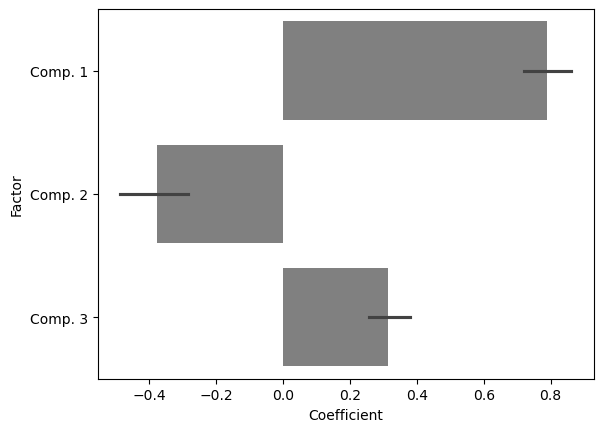

In [75]:
sns.barplot(data=lr_coef, x="Coefficient", y="Factor", orient="h", color="gray")

Since not all factors relate to the effect we try to predict, the model may be reduced to using a subset of the factors. Here, we explore a few options for reducing the model (Fig. 3h).

<Axes: xlabel='Models', ylabel='Fitting score'>

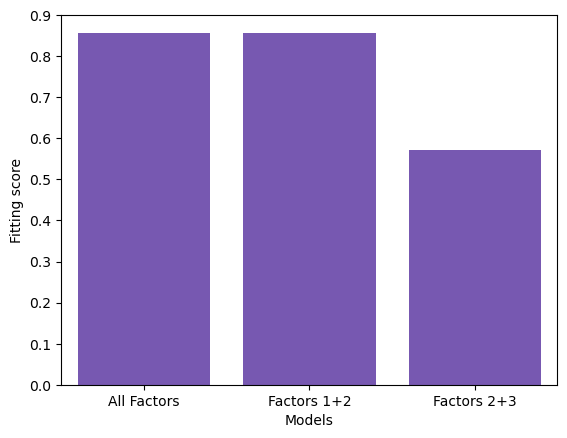

In [77]:
reduced_names = ["All Factors", "Factors 1+2", "Factors 2+3"]
reduced_columns = [[0,1,2], [0,1], [1,2]]
reduced_pred = [0] * len(reduced_columns)

for ri, reduced_col in enumerate(reduced_columns):
    reduced_lr = LogisticRegression().fit(cp[1][0][:, reduced_col], organ_effect)
    reduced_pred[ri] = reduced_lr.score(cp[1][0][:, reduced_col], organ_effect)

sns.barplot(data=pd.DataFrame({"Models": reduced_names, "Fitting score": reduced_pred}),
            x="Models",
            y="Fitting score",
            color="#7349C0")

## 10. Tucker decomposition

Tucker decomposition is a more flexible tensor factorization scheme. It allows each mode to have different factor numbers, and explicitly models how they interact. See Fig. 4a to learn about how it works. Here, we perform a (4,3,2)-rank Tucker decomposition on our drug response $7 \times 6 \times 5$ tensor. This means the organ mode has 4 factors, drug 3, and time 2.

In [79]:
from tensorly.decomposition import tucker

tres = tucker(tensor, (4, 3, 2))

The result of a Tucker decomposition consists of to part: the core tensor and the factor matrices. The factor matrices can be plotted similarly as in Fig. 2f. The shape of these three factor matrices should be

In [81]:
print(tres[1][0].shape, tres[1][1].shape, tres[1][2].shape)

(7, 4) (6, 3) (5, 2)


The core tensor is a new part of Tucker. It represents the interactions across these factors. It has dimension $4 \times 3 \times 2$. We can visualize it as (Fig. 4b, left)

<Axes: >

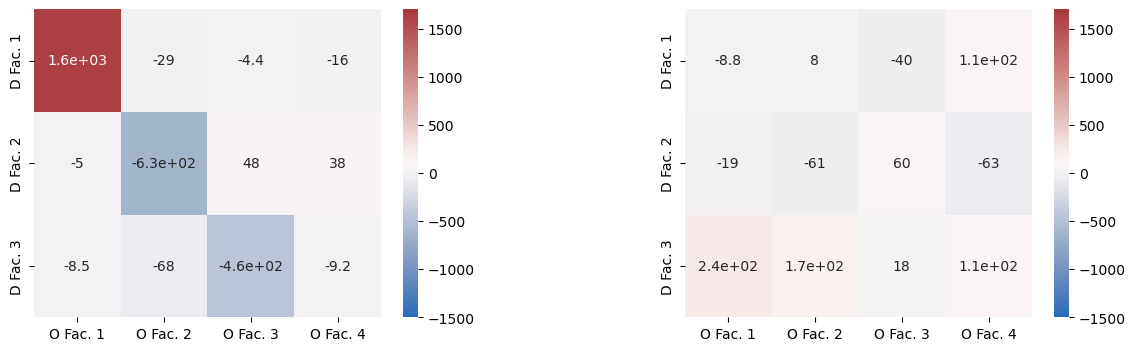

In [83]:
f = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 2, wspace=0.5)
axes = [plt.subplot(gs[rr]) for rr in range(2)]

sns.heatmap(tres[0][:, :, 0].T, ax=axes[0], vmin=-1500, vmax=1700, cmap="vlag", annot=True,
            xticklabels=[f"O Fac. {i}" for i in np.arange(1, tres[0].shape[0]+1)], 
            yticklabels=[f"D Fac. {i}" for i in np.arange(1, tres[0].shape[1]+1)],)
sns.heatmap(tres[0][:, :, 1].T, ax=axes[1], vmin=-1500, vmax=1700, cmap="vlag", annot=True,
            xticklabels=[f"O Fac. {i}" for i in np.arange(1, tres[0].shape[0]+1)], 
            yticklabels=[f"D Fac. {i}" for i in np.arange(1, tres[0].shape[1]+1)],)

### Find the most significant interactions

We define the significance of an interaction as the proportion of its squared weight over the sum of all squared weights in the core tensor. To interpret the results, we first find the significance of all interactions, then sort them in decreasing order.

In [85]:
from itertools import product

core_tensor = pd.DataFrame({
                       "Index": product(*[np.arange(1, si+1) for si in tres[0].shape]),
                        "Weight": tres[0].flatten(),
                        "Fraction": tres[0].flatten()**2,
                        "Sign": np.sign(tres[0].flatten()),
                    })

core_tensor = core_tensor.sort_values("Fraction", ascending=False)
core_tensor["Index"] = core_tensor["Index"].astype(str)
core_tensor["Fraction"] = core_tensor["Fraction"] / np.sum(core_tensor["Fraction"])
core_tensor

,Index,Weight,Fraction,Sign
0,"(1, 1, 1)",1631.393536,0.781533,1.0
8,"(2, 2, 1)",-632.485523,0.117471,-1.0
16,"(3, 3, 1)",-456.732019,0.061257,-1.0
5,"(1, 3, 2)",243.787831,0.017452,1.0
11,"(2, 3, 2)",173.713752,0.008861,1.0
23,"(4, 3, 2)",105.895351,0.003293,1.0
19,"(4, 1, 2)",105.725373,0.003282,1.0
10,"(2, 3, 1)",-68.055514,0.001360,-1.0
21,"(4, 2, 2)",-63.160668,0.001171,-1.0
9,"(2, 2, 2)",-60.768254,0.001084,-1.0


We can use a barplot to visualize these fractions (Fig. 4b, right). While all significance are positive, we use different colors to annotate the sign of the original weights.

<Axes: xlabel='Index', ylabel='Fraction'>

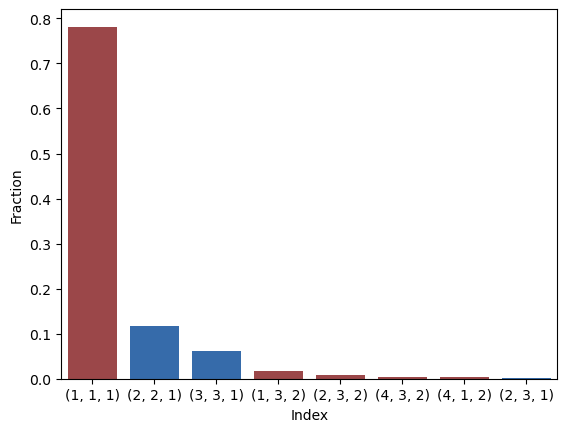

In [87]:
sns.barplot(core_tensor.iloc[:8, :], x="Index", y="Fraction", hue="Sign", 
            palette=["#2369BD", "#A9393C"], legend=False)

The result shows that 78% of the variance in the data can be explained by the interaction of the first factors of organ, drug, and time. Combined with the factor plots below, we get to know that it represents a time-consistent effect mostly from echoxacin on most cells except those from the skin and the kidney. The top three interactions together explain almost 96% of the variance, and they are all related to time Factor 1 which is relatively constant over time. This example shows that Tucker can summarize the modes better without redundancy, as a factor can be reused.

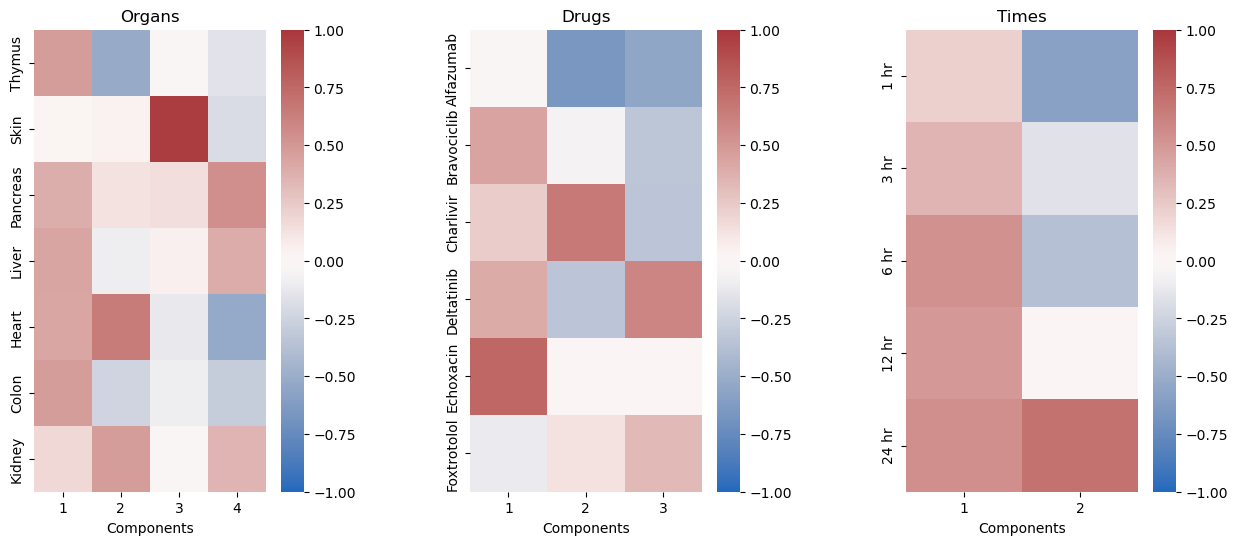

In [89]:
plot_factors([tres[0], tres[1]])

### Compare the data reduction of Tucker and CP

We here plot the size of reduced data of a few selected Tucker ranks along with CP decompositions to see if Tucker provides a concise data representation (Fig. 4d).

In [91]:
reduction = pd.DataFrame()

tucker_rank = list(np.ones(tensor.ndim, dtype=int))
reduction = pd.concat([reduction, pd.DataFrame([{
                'Size': np.sum(tensor.shape * np.array(tucker_rank)) + np.prod(tucker_rank),
                'Error': error(tensor, tucker(tensor, tucker_rank)),
                'Method': "Tucker",
                'Rank': tucker_rank,
        }])], ignore_index=True)

for tr in range(10):
    for add_r in range(tensor.ndim):
        new_tucker_rank = tucker_rank.copy()
        new_tucker_rank[add_r] += 1
        reduction = pd.concat([reduction, pd.DataFrame([{
                    'Size': np.sum(tensor.shape * np.array(new_tucker_rank)),
                    'Error': error(tensor, tucker(tensor, new_tucker_rank)),
                    'Method': "Tucker",
                    'Rank': new_tucker_rank,
            }])], ignore_index=True)
        
    # selection the lowest error rank and continue
    min_rank = np.argmin(reduction.iloc[-3:, 1])
    tucker_rank = reduction.iloc[-(tensor.ndim-min_rank), 3]

In [92]:
# Add CP reduction
for rr in np.arange(1, 7):
    reduction = pd.concat([reduction, pd.DataFrame([{
                'Size': rr * np.sum(tensor.shape),
                'Error': error(tensor, parafac(tensor, rr, tol=1e-09)),
                'Method': "CP",
                'Rank': rr,
        }])], ignore_index=True)

<Axes: xlabel='Size', ylabel='Error'>

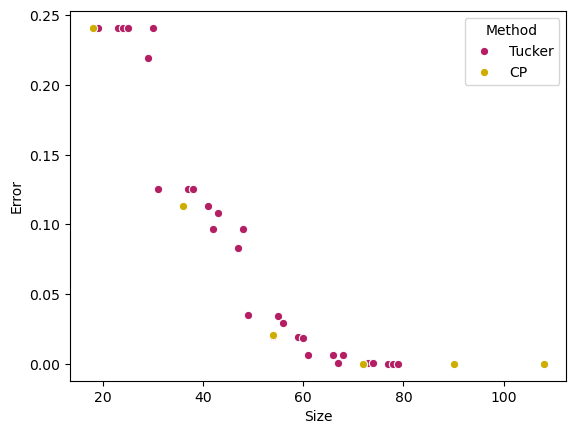

In [93]:
sns.lineplot(data=reduction, x="Size", y="Error", hue="Method", marker="o", 
                    linestyle="", palette=["#B41F64", "#CFAD00"])

As we can see here, not all Tucker rank yields a more parsimonious model. The rank selection for Tucker decomposition is more complicated.

## 11. Coupled tensor decomposition

A coupled decomposition can jointly factorize multiple coupled tensors. See Fig. 4e to learn how it works. Here, we use a variant of coupled decomposition, coupled matrix and tensor decomposition (CMTF) (see Fig. 4g, left), to explore how the relative scale between two coupled tensor can impact the goodness of fit. First, we generate a synthetic Tensor B (the matrix):

In [96]:
np.random.seed(234)
mat = np.random.gamma(1, 5, size=(7, 6)) * 100

Now we perform CMTF with different scaling of Tensor B, and plot the errors for both tensors and the total errors (Fig. 4f).

In [98]:
from tensorly.decomposition._cmtf_als import coupled_matrix_tensor_3d_factorization

coupled = pd.DataFrame()

for scale in np.logspace(-2.5, 2.5, num=30, endpoint=True, base=2):
    cmtf = coupled_matrix_tensor_3d_factorization(tensor, mat*scale, 4, normalize_factors=False)

    total_recon = np.concatenate([cmtf[0].to_tensor().flatten(), cmtf[1].to_tensor().flatten()])
    total_original = np.concatenate([tensor.flatten(), (mat*scale).flatten()])
    coupled = pd.concat([coupled, pd.DataFrame([{
            'Scale': scale,
            'Total': error(total_original, total_recon),
            'Tensor A': error(tensor, cmtf[0]),
            'Tensor B': error(mat*scale, cmtf[1]),
        }])], ignore_index=True)

coupled = pd.melt(coupled, id_vars="Scale", var_name="Tensor", value_name="Error")

/opt/anaconda3/envs/tensor_review/lib/python3.12/site-packages/tensorly/backend/__init__.py:195: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return getattr(
/opt/anaconda3/envs/tensor_review/lib/python3.12/site-packages/tensorly/decomposition/_cmtf_als.py:128: UserWarning: Reached maximum iteration number without convergence.
  warnings.warn("Reached maximum iteration number without convergence.")


[None,

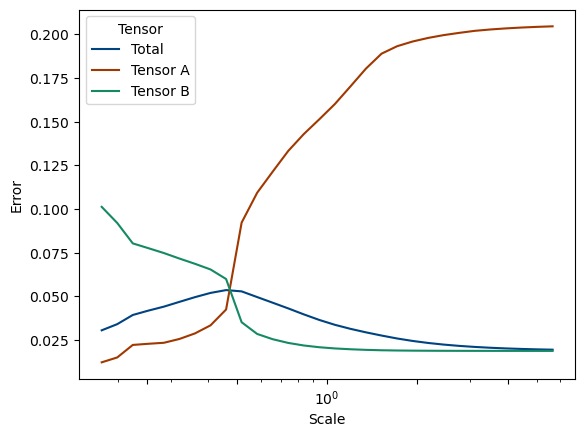

In [99]:
ax = sns.lineplot(data=coupled, x="Scale", y="Error", hue="Tensor", 
                  palette=["#004381", "#A13800", "#148964"])
ax.set(xscale="log", xticks=[0.25, 0.5, 1, 2, 4])

The results shows that the fitting error of Tensor A increase a lot when Tensor B is scaled much higher, and the fitting error of Tensor B increase when Tensor B is scaled much lower. The relative scale of coupled tensors is a hyperparameter to tune when implementing a coupled decomposition.

## 12. Tensor partial least squares

Tensor partial least squares also deal with more than one tensors, but here instead of optimizing the joint variance of Tensors A and B, we aims to discover the cause and effect embedded in Tensors X and Y. Therefore, tensor partial least sqaures prioritize the covariance between X and Y. See Fig. 4h to see how it works
To demonstrate tensor partial least squares, we first generate a simulated Y matrix.

In [102]:
# Generate a simulated predictor, Y
np.random.seed(1234)
Y = cp[1][0][:, [0]] @ np.random.gamma(1, 5, size=(1,4)) * 0.6 + \
    cp[1][0][:, [2]] @ np.random.gamma(3, 1, size=(1,4)) * 0.4
Y *= np.random.lognormal(0, 0.1, size=Y.shape)

To assess the performance of tensor partial least squares, we find the fitting errors of X and Y. Also, through a leave-one-out cross-validation, we evaluate the prediction error of Y. In a leave-one-out cross-validation, we hide one sample from the model at a time, and use the rest of samples to fit the model so that the left-out sample is unseen to the model can serve as a fair estimation of the prediction performance (Fig. 4i).

/opt/anaconda3/envs/tensor_review/lib/python3.12/site-packages/tensorly/backend/__init__.py:195: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return getattr(


(-0.05, 0.8)

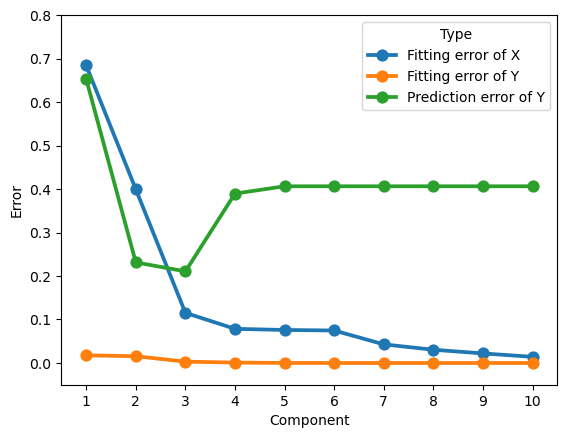

In [104]:
from tensorly.regression.cp_plsr import CP_PLSR
from tensorly.cp_tensor import cp_to_tensor

plsr_r2 = pd.DataFrame()

for rr in range(1, 11):
    plsr = CP_PLSR(rr)
    plsr.fit(tensor, Y)

    # Calculate fitting error of X and Y
    plsr_r2 = pd.concat([plsr_r2, pd.DataFrame([{
            'Component': rr,
            'Error': error(tensor-plsr.X_mean_, CPTensor((None, plsr.X_factors))),
            'Type': "Fitting error of X",
        }])], ignore_index=True)
    plsr_r2 = pd.concat([plsr_r2, pd.DataFrame([{
                'Component': rr,
                'Error': error(Y-plsr.Y_mean_, plsr.predict(tensor)-plsr.Y_mean_),
                'Type': "Fitting error of Y",
            }])], ignore_index=True)

    # Leave one out prediction on Y
    Y_loo = np.zeros_like(Y)
    for ii in range(tensor.shape[0]):
        idx = np.delete(np.arange(tensor.shape[0]), ii)
        plsr.fit(tensor[idx], Y[idx])
        Y_loo[ii] = plsr.predict(tensor[[ii]])
    plsr_r2 = pd.concat([plsr_r2, pd.DataFrame([{
                'Component': rr,
                'Error': error(Y- plsr.Y_mean_, Y_loo- plsr.Y_mean_),
                'Type': "Prediction error of Y",
            }])], ignore_index=True)

ax_plsr = sns.pointplot(data=plsr_r2, x="Component", y="Error", hue="Type")
ax_plsr.set_ylim(-0.05, 0.8)

For a correctly performed tensor partial least squares, the fitting errors of both X and Y should monotonically decrease with more components. However, the prediction error of Y will increase after passing its optimal number of components. This is because having too many components will lead to the model overfitting the data, which means the model fits the data too closely that it loses generality and cannot predict unseen samples well anymore. In our example, overfitting happens when the model has more than 3 components. Cross-validation is needed when choosing the number of components for tensor partial least squares.